In [16]:
import pandas as pd
import numpy as np
import re

In [17]:
data_path = 'erasmus-data/erasmus-data.xlsx'
d1 = pd.read_excel(data_path,skiprows=1,sheet_name='Table 1').drop(columns=['Unnamed: 0'])
d1.columns = d1.columns.str.strip()

In [18]:
d2 = pd.read_excel(data_path,sheet_name='Table 2').drop(columns=['Unnamed: 0'])
d2.columns = d1.columns

In [19]:
d3 = pd.read_excel(data_path,sheet_name='Table 3').drop(columns=['Unnamed: 0'])
d3.columns = d1.columns

In [20]:
data = pd.merge(pd.merge(d1,d2,how='outer'),d3,how='outer')

data = data.map(lambda x: x.strip() if isinstance(x,str) else x)

data['Yerleştiği Yer Ülke'] = data['Yerleştiği Yer Ülke'].replace('-',np.nan)

data['Puan'] = pd.to_numeric(data['Puan'],errors='coerce').fillna(0)

data['Department'] = data['Birim'].apply(lambda x: re.split(r' \(.*',x)[0])

data.head()

,TCKN,Ad Soyad,Eğitim Türü,Öğrenci No,Birim,Fakülte,Sonuç,Sonuç Açıklama,Yerleştiği Yer,Yerleştiği Yer Ülke,Başvuru Tercih Dönemi,Puan,Department
0,10*********0,Ar********* Şa*********,Lisans,122*********9,Uluslararası Ticaret Ve İşletmecilik Pr. (İngi...,İşletme Fakültesi,Kabul Hibesiz,Aday 2. tercihine asil yerleşti.,I ROMA16 / UNIVERSITA DEGLI STUDI ROMA TRE,İtalya,2024-2025 Bahar,75.97,Uluslararası Ticaret Ve İşletmecilik Pr.
1,10*********0,Ey********* At*********,Lisans,123*********7,Hukuk Pr. (Tam Burslu),Hukuk Fakültesi,Kabul Hibesiz,Aday 1. tercihine asil yerleşti.,D MUNCHEN01 / LUDWIG-MAXIMILIANS-UNIVERSITAET ...,Almanya,2024-2025 Bahar,76.97,Hukuk Pr.
2,10*********0,Il********* Ya*********,Lisans,122*********1,İç Mimarlık Pr. (İngilizce) (%50 Burslu),Mimarlık Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,B LEUVEN01 / KATHOLIEKE UNIVERSITEIT LEUVEN,Belçika,2024-2025 Bahar,98.02,İç Mimarlık Pr.
3,10*********0,La********* Se*********,Lisans,122*********5,İşletme Pr. (İngilizce) (%50 Burslu),İşletme Fakültesi,Kabul Hibesiz,Aday 3. tercihine asil yerleşti.,HR ZAGREB10 / SVEUCILISTE VERN,Hırvatistan,2024-2025 Bahar,75.52,İşletme Pr.
4,10*********0,Me********* Bo*********,Lisans,122*********7,Yönetim Bilişim Sistemleri Pr. (İngilizce) (Ta...,İşletme Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,NL AMSTERD05 / STICHTING HOGESCHOOL VAN AMSTERDAM,Hollanda,2024-2025 Güz-Bahar (Bir Akademik Yıl),84.38,Yönetim Bilişim Sistemleri Pr.


In [21]:
grouped_status = (data.groupby(
    data['Sonuç'].replace(
        {
            'Kabul Hibeli': 'Accepted',
            'Kabul Hibesiz': 'Accepted',
            'Kazanamadı': 'Rejected', 
            'Ret':'Rejected',
            'Yedek':'Alternate'
        })))
status_summary = grouped_status.agg(count=('TCKN', 'size'))
status_summary

,count
Sonuç,
Accepted,282
Alternate,39
Rejected,22


<Axes: title={'center': 'Erasmus Status Distribution'}, ylabel='count'>

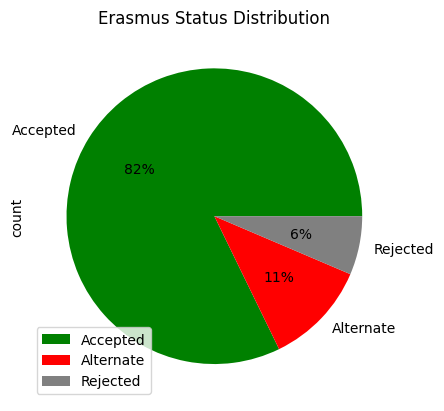

In [22]:
status_summary.plot(kind='pie',y='count',autopct='%1.0f%%',colors=['Green','Red','Gray'],title='Erasmus Status Distribution')

In [23]:
# Grant column is 'Granted' if the student was awarded grants, 'Ungranted' if the student was not.
# NaN if the student was not selected to Erasmus
data['Grant'] = np.where(data['Sonuç'].str.contains('Hibeli'), 'Granted', 'Ungranted')
data.loc[grouped_status.groups['Rejected'],'Grant'] = np.nan
data.loc[grouped_status.groups['Alternate'],'Grant'] = np.nan

In [24]:
grouped_grant = data.groupby('Grant')
grant_summary = grouped_grant.agg(count=('TCKN','size'), mean=('Puan','mean'))
grant_summary

,count,mean
Grant,,
Granted,156,89.681603
Ungranted,126,75.751270


<Axes: title={'center': 'Grant Distribution'}, ylabel='count'>

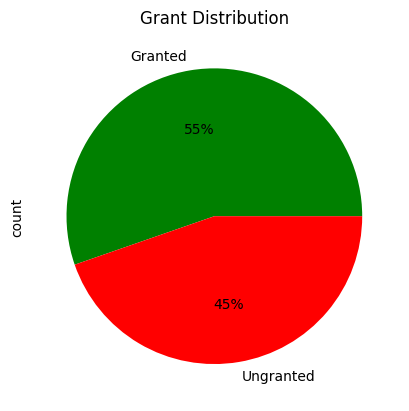

In [25]:
grant_summary['count'].plot(kind='pie',y='count',autopct='%1.0f%%',colors=['Green','Red'],title='Grant Distribution')

In [26]:
def set_scholarship(item):

    if 'Tam Burslu' in item:
        return 'Full'
    elif '%50 Burslu' in item:
        return 'Partial'
    elif 'Ücretli' in item:
        return 'Paid'
    else:
        return np.nan

data['Scholarship'] = data['Birim'].apply(set_scholarship)
data.head()

,TCKN,Ad Soyad,Eğitim Türü,Öğrenci No,Birim,Fakülte,Sonuç,Sonuç Açıklama,Yerleştiği Yer,Yerleştiği Yer Ülke,Başvuru Tercih Dönemi,Puan,Department,Grant,Scholarship
0,10*********0,Ar********* Şa*********,Lisans,122*********9,Uluslararası Ticaret Ve İşletmecilik Pr. (İngi...,İşletme Fakültesi,Kabul Hibesiz,Aday 2. tercihine asil yerleşti.,I ROMA16 / UNIVERSITA DEGLI STUDI ROMA TRE,İtalya,2024-2025 Bahar,75.97,Uluslararası Ticaret Ve İşletmecilik Pr.,Ungranted,Paid
1,10*********0,Ey********* At*********,Lisans,123*********7,Hukuk Pr. (Tam Burslu),Hukuk Fakültesi,Kabul Hibesiz,Aday 1. tercihine asil yerleşti.,D MUNCHEN01 / LUDWIG-MAXIMILIANS-UNIVERSITAET ...,Almanya,2024-2025 Bahar,76.97,Hukuk Pr.,Ungranted,Full
2,10*********0,Il********* Ya*********,Lisans,122*********1,İç Mimarlık Pr. (İngilizce) (%50 Burslu),Mimarlık Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,B LEUVEN01 / KATHOLIEKE UNIVERSITEIT LEUVEN,Belçika,2024-2025 Bahar,98.02,İç Mimarlık Pr.,Granted,Partial
3,10*********0,La********* Se*********,Lisans,122*********5,İşletme Pr. (İngilizce) (%50 Burslu),İşletme Fakültesi,Kabul Hibesiz,Aday 3. tercihine asil yerleşti.,HR ZAGREB10 / SVEUCILISTE VERN,Hırvatistan,2024-2025 Bahar,75.52,İşletme Pr.,Ungranted,Partial
4,10*********0,Me********* Bo*********,Lisans,122*********7,Yönetim Bilişim Sistemleri Pr. (İngilizce) (Ta...,İşletme Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,NL AMSTERD05 / STICHTING HOGESCHOOL VAN AMSTERDAM,Hollanda,2024-2025 Güz-Bahar (Bir Akademik Yıl),84.38,Yönetim Bilişim Sistemleri Pr.,Granted,Full


In [27]:
grouped_scholarship = data.groupby('Scholarship')
scholarship_summary = grouped_scholarship.agg(count = ('TCKN','size'), mean=('Puan', 'mean'), max=('Puan', 'max'), min=('Puan', 'min'))
scholarship_summary

,count,mean,max,min
Scholarship,,,,
Full,90,82.472000,102.00,0.0
Paid,52,80.005962,97.90,0.0
Partial,186,75.010269,99.18,0.0


<Axes: title={'center': 'Scholarship Distribution'}, ylabel='count'>

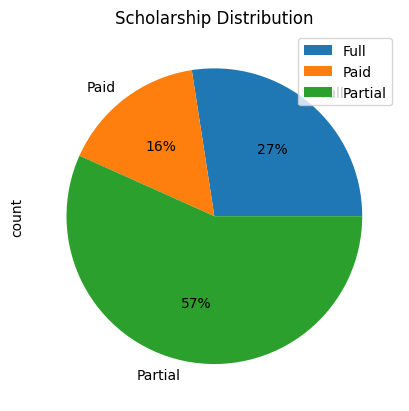

In [28]:
scholarship_summary.plot(kind='pie',y='count',autopct='%1.0f%%',title='Scholarship Distribution')

In [29]:
grouped_scholar_grant = data.groupby(['Scholarship','Grant'])
scholar_grant_summary = grouped_scholar_grant.agg(count = ('TCKN','size'), mean=('Puan','mean'))
scholar_grant_summary

count       mean
Scholarship Grant                      
Full        Granted       53  90.248868
            Ungranted     31  77.072258
Paid        Granted       23  89.223043
            Ungranted     20  75.743000
Partial     Granted       72  89.135139
            Ungranted     73  75.105205

<Axes: title={'center': 'Paid Students'}, ylabel='count'>

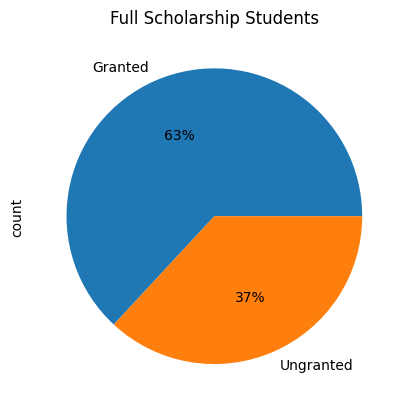

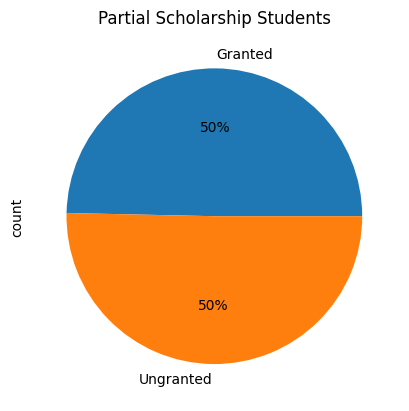

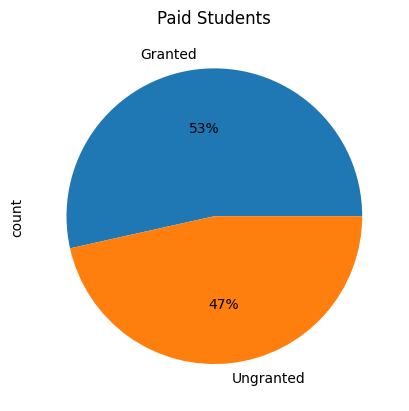

In [30]:
scholar_grant_summary.loc['Full'].plot(kind='pie',y='count',autopct='%1.0f%%',title='Full Scholarship Students',legend=False)
scholar_grant_summary.loc['Partial'].plot(kind='pie',y='count',autopct='%1.0f%%',title='Partial Scholarship Students',legend=False)
scholar_grant_summary.loc['Paid'].plot(kind='pie',y='count',autopct='%1.0f%%',title='Paid Students',legend=False)

In [31]:
# Mean scores of students that were accepted, grouped by their scholarship status.
data.loc[grouped_status.groups['Accepted']].pivot_table(index='Scholarship',values='Puan', aggfunc=['mean', 'max','min']).rename(columns={'Puan':'Score'})

,mean,max,min
,Score,Score,Score
Scholarship,,,
Full,85.386071,102.00,65.23
Paid,82.953256,97.90,65.52
Partial,82.071793,99.18,56.13


In [32]:
accepted = grouped_status.get_group('Accepted')

In [33]:
# Among accepted students, check if students who are on full scholarships tend to get higher grades than others.

# We will perform a t-test.

# Null Hypothesis: There's no significant difference between full scholarship students and other students
# Alternative Hypothesis: There's a significant difference between full scholarship students and other students.
# Significance Level: 0.05
from scipy.stats import ttest_ind

accepted_fullscholar_scores = accepted[accepted['Scholarship'] == 'Full']['Puan']
other_scholar_scores = accepted[(accepted['Scholarship'] == 'Partial') | (accepted['Scholarship'] == 'Paid')]['Puan']

p = ttest_ind(accepted_fullscholar_scores,other_scholar_scores).pvalue

print('p value: ', p)
print('p value is below the threshold of 0.05')
print('There is a significant difference in scores between students on Full Scholarship and others.')
print('Students that are on full scholarship tend to get better grades.')

p value:  0.004429043550657171
p value is below the threshold of 0.05
There is a significant difference in scores between students on Full Scholarship and others.
Students that are on full scholarship tend to get better grades.


In [34]:
data['Yerleştiği Yer Ülke'].unique()

array(['İtalya', 'Almanya', 'Belçika', 'Hırvatistan', 'Hollanda',
       'Avusturya', 'Danimarka', 'Fransa', 'İsveç', 'Portekiz', 'İrlanda',
       'Sırbistan', 'Slovakya', 'İspanya', 'Norveç', nan, 'Litvanya',
       'Çek Cumhuriyeti', 'Macaristan', 'Polonya', 'Malta', 'Yunanistan',
       'Romanya'], dtype=object)

In [35]:
grouped_country = data.groupby('Yerleştiği Yer Ülke')
country_summary = (grouped_country
                   .agg(count = ('TCKN','size'), mean=('Puan','mean'))
                   .rename_axis('Country')
                   .sort_values(by='count',ascending=False)
                  )
country_summary.head(10)

,count,mean
Country,,
Almanya,110,82.405182
Hollanda,45,86.883556
İspanya,30,82.247333
İtalya,23,85.625652
Belçika,21,83.275238
Fransa,18,77.922778
İsveç,12,80.405833
Portekiz,12,81.949167
Norveç,9,86.233333


<Axes: title={'center': 'Country Distribution'}, ylabel='count'>

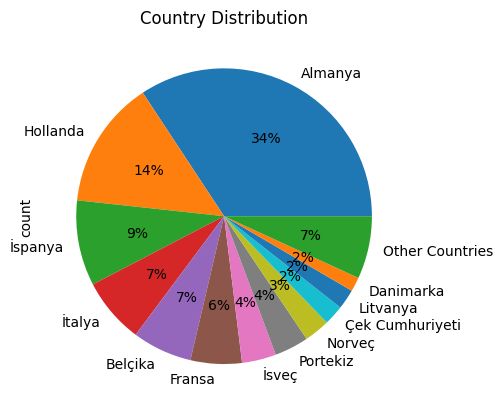

In [36]:
last_ten = country_summary.tail(10).sum() 
country_summary.drop(country_summary.tail(10).index,inplace=True)
country_summary.loc['Other Countries'] = last_ten
country_summary.plot(kind='pie',y='count',autopct='%1.0f%%',title='Country Distribution',legend=False)

In [37]:
grouped_department = data.groupby('Department')
summary_department = (grouped_department
                      .agg(count = ('TCKN','size'), mean_score=('Puan','mean'))
                      .sort_values(by='count',ascending=False))
total_count = summary_department['count'].sum()
summary_department['percentage'] = summary_department['count'].apply(lambda x: round(100 * (x / total_count), 2))
summary_department.head(10)

,count,mean_score,percentage
Department,,,
Psikoloji Pr.,41,88.064146,11.95
İşletme Pr.,20,79.052500,5.83
Hukuk Pr.,20,76.031000,5.83
İngiliz Dili Ve Edebiyatı Pr.,17,72.045294,4.96
Bilgisayar Mühendisliği Pr.,17,74.808235,4.96
Dijital Oyun Tasarımı Pr.,15,69.151333,4.37
Uluslararası İlişkiler Pr.,14,83.412857,4.08
Yeni Medya Ve İletişim Pr.,13,83.906923,3.79
Uluslararası Ticaret Ve İşletmecilik Pr.,11,69.248182,3.21


In [38]:
data.head(20)

,TCKN,Ad Soyad,Eğitim Türü,Öğrenci No,Birim,Fakülte,Sonuç,Sonuç Açıklama,Yerleştiği Yer,Yerleştiği Yer Ülke,Başvuru Tercih Dönemi,Puan,Department,Grant,Scholarship
0,10*********0,Ar********* Şa*********,Lisans,122*********9,Uluslararası Ticaret Ve İşletmecilik Pr. (İngi...,İşletme Fakültesi,Kabul Hibesiz,Aday 2. tercihine asil yerleşti.,I ROMA16 / UNIVERSITA DEGLI STUDI ROMA TRE,İtalya,2024-2025 Bahar,75.97,Uluslararası Ticaret Ve İşletmecilik Pr.,Ungranted,Paid
1,10*********0,Ey********* At*********,Lisans,123*********7,Hukuk Pr. (Tam Burslu),Hukuk Fakültesi,Kabul Hibesiz,Aday 1. tercihine asil yerleşti.,D MUNCHEN01 / LUDWIG-MAXIMILIANS-UNIVERSITAET ...,Almanya,2024-2025 Bahar,76.97,Hukuk Pr.,Ungranted,Full
2,10*********0,Il********* Ya*********,Lisans,122*********1,İç Mimarlık Pr. (İngilizce) (%50 Burslu),Mimarlık Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,B LEUVEN01 / KATHOLIEKE UNIVERSITEIT LEUVEN,Belçika,2024-2025 Bahar,98.02,İç Mimarlık Pr.,Granted,Partial
3,10*********0,La********* Se*********,Lisans,122*********5,İşletme Pr. (İngilizce) (%50 Burslu),İşletme Fakültesi,Kabul Hibesiz,Aday 3. tercihine asil yerleşti.,HR ZAGREB10 / SVEUCILISTE VERN,Hırvatistan,2024-2025 Bahar,75.52,İşletme Pr.,Ungranted,Partial
4,10*********0,Me********* Bo*********,Lisans,122*********7,Yönetim Bilişim Sistemleri Pr. (İngilizce) (Ta...,İşletme Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,NL AMSTERD05 / STICHTING HOGESCHOOL VAN AMSTERDAM,Hollanda,2024-2025 Güz-Bahar (Bir Akademik Yıl),84.38,Yönetim Bilişim Sistemleri Pr.,Granted,Full
5,10*********0,Mi********* Çe*********,Lisans,122*********6,Görsel İletişim Tasarımı Pr. (İngilizce) (%50 ...,İletişim Fakültesi,Kabul Hibeli,Aday 2. tercihine asil yerleşti.,A LINZ02 / UNIVERSITAT FUR KUNSTLERISCHE UND I...,Avusturya,2024-2025 Güz,88.78,Görsel İletişim Tasarımı Pr.,Granted,Partial
6,10*********0,Ne********* Gü*********,Lisans,123*********2,Uluslararası İlişkiler Pr. (İngilizce) (Tam Bu...,Sosyal Ve Beşeri Bilimler Fakültesi,Kabul Hibesiz,Aday 1. tercihine asil yerleşti.,I TORINO01 / UNIVERSITA DEGLI STUDI DI TORINO,İtalya,2024-2025 Güz,80.82,Uluslararası İlişkiler Pr.,Ungranted,Full
7,10*********2,Ay********* Ün*********,Lisans,122*********6,İşletme Pr. (İngilizce) (%50 Burslu),İşletme Fakültesi,Kabul Hibeli,Aday 1. tercihine asil yerleşti.,DK KOBENHA05 / COPENHAGEN BUSINESS SCHOOL,Danimarka,2024-2025 Güz-Bahar (Bir Akademik Yıl),90.15,İşletme Pr.,Granted,Partial
8,10*********2,Be********* Öz*********,Lisans,122*********1,Tekstil Ve Moda Tasarımı Pr. (Tam Burslu),Uygulamalı Bilimler Fakültesi,Kabul Hibeli,Aday 2. tercihine asil yerleşti.,I MILANO08 / ACCADEMIA DI BELLE ARTI DI BRERA,İtalya,2024-2025 Bahar,91.12,Tekstil Ve Moda Tasarımı Pr.,Granted,Full
9,10*********2,De********* Yı*********,Lisans,123*********7,Yeni Medya Ve İletişim Pr. (İngilizce) (%50 Bu...,İletişim Fakültesi,Yedek,Aday 1. tercihine yedek yerleşti.,F PARIS326 / Groupe EDH,Fransa,2024-2025 Güz,72.22,Yeni Medya Ve İletişim Pr.,NaN,Partial
